In [135]:
# importing libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, ttest_ind
import missingno as mno
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import time 
import numpy as np

from sklearn.inspection import permutation_importance

from sklearn.metrics import average_precision_score, precision_recall_curve, \
    plot_precision_recall_curve
%matplotlib inline

# Loading Data

In [4]:
# loading data
file_to_load = "../Resources/data.csv"

no_touch_data = pd.read_csv(file_to_load)
titanic_data = no_touch_data
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Cleaning Data

In [38]:
# Adding title from name
titanic_data['Name_title'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic_data['Title_num'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Title_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs


In [6]:
titanic_data.Name_title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [54]:
# giving number to Title
titanic_data['Title_num'] = titanic_data['Title_num'].replace('Mr',1)
titanic_data['Title_num'] = titanic_data['Title_num'].replace('Mrs',2)
titanic_data['Title_num'] = titanic_data['Title_num'].replace(['Miss','Mlle','Ms','Mme'],3)
titanic_data['Title_num'] = titanic_data['Title_num'].replace(['Major','Col','Capt'],4)
titanic_data['Title_num'] = titanic_data['Title_num'].replace(['Master','Don','Rev','Dr','Lady','Sir','the Countess','Jonkheer'],5)
titanic_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Title_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,1


In [52]:
titanic_data.Title_num.unique()

array([1, 2, 3, 5, 4])

In [55]:
# making sex binary
titanic_data['Sex_binary'] = [0 if x == 'male' else 1 for x in titanic_data['Sex']]

In [57]:
# adding age for mean and median
mean = titanic_data.Age.mean()
median = titanic_data.Age.median()

titanic_data["Age_imp_median"] = titanic_data.Age.fillna(median)
titanic_data["Age_imp_mean"] = titanic_data.Age.fillna(mean)


In [67]:
# cleaning cabin - moving to decks
titanic_data['Cabin_decks'] = titanic_data['Cabin'].str.replace('\d+','')
titanic_data['Cabin_decks'] = titanic_data['Cabin_decks'].replace(['NaN'],'N')
# titan_data['Cabin_num'] = titan_data['Cabin_decks'].replace('')

In [68]:
# seeing finished results 
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Title_num,Sex_binary,Age_imp_median,Age_imp_mean,Cabin_decks
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,0,22.0,22.0,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,1,38.0,38.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,3,1,26.0,26.0,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,1,35.0,35.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,0,35.0,35.0,NaN


In [75]:
wanted_features = titanic_data[['Survived','Age','SibSp','Parch','Fare','Embarked','Title_num',\
                                'Sex_binary','Age_imp_median','Age_imp_mean','Cabin_decks']]
wanted_features.head()

,Survived,Age,SibSp,Parch,Fare,Embarked,Title_num,Sex_binary,Age_imp_median,Age_imp_mean,Cabin_decks
0,0,22.0,1,0,7.2500,S,1,0,22.0,22.0,NaN
1,1,38.0,1,0,71.2833,C,2,1,38.0,38.0,C
2,1,26.0,0,0,7.9250,S,3,1,26.0,26.0,NaN
3,1,35.0,1,0,53.1000,S,2,1,35.0,35.0,C
4,0,35.0,0,0,8.0500,S,1,0,35.0,35.0,NaN


<AxesSubplot:>

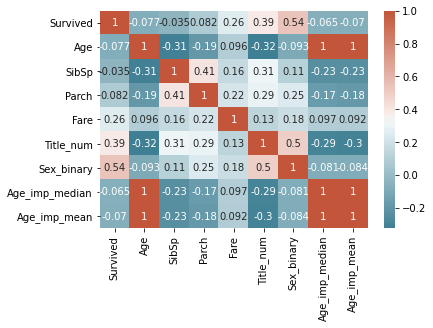

In [77]:
# initial correlation matrix 
corr = wanted_features.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
           cmap=sns.diverging_palette(220,20, as_cmap=True))

# testing

In [80]:
cat1 = wanted_features['Title_num']
cat2 = wanted_features['Survived']

ttest_ind(cat1, cat2)

Ttest_indResult(statistic=34.15567170999227, pvalue=4.5096661048191655e-197)

Splitting data

In [178]:
# Creating X and y
X = wanted_features[['SibSp','Parch','Fare','Title_num',\
            'Sex_binary','Age_imp_median']]
# X = wanted_features[['Sex_binary','Title_num']]
y = wanted_features.Survived

# use train_test_splie to create training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Logistic Regression using Statsmodels

In [179]:
Xtrain = wanted_features[['SibSp','Parch','Fare','Title_num',\
            'Sex_binary','Age_imp_median']]
# Xtrain = wanted_features[['Sex_binary','Title_num']]
ytrain = wanted_features['Survived']

# building the model and fitting the data
log_reg = sm.Logit(ytrain,Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.486867
         Iterations 6


In [185]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.2689
Time:                        22:34:11   Log-Likelihood:                -433.80
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.983e-67
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
SibSp             -0.6029      0.111     -5.429      0.000      -0.821      -0.385
Parch             -0.3249      0.121     -2.685      0.007      -0.562      -0.088
Fare               0.0159      0.003      5.568      0.000       0.010       0.022
Title_num          0.1431      0.072      2.000      0.046       0.003       0.283
Sex_binary         2.3470      0.205     11.474      0.000       1.946       2.748
Age_imp_median    -0.0536      0.005    -11.767      0.000      -0.062      -0.045
==================================================================================
"""

In [186]:
# performing predictions on the test datdaset
yhat = log_reg.predict(X_test)
prediction = list(map(round, yhat))
 
# confusion matrix
cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[112  22]
 [ 26  63]]
Test accuracy =  0.7847533632286996


Logistic regression using scikitlearn

[[110  24]
 [ 24  65]]


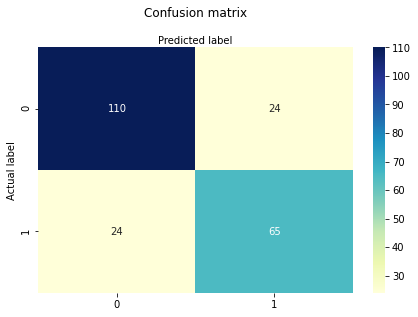

Accuracy: 0.7847533632286996
Precision: 0.7303370786516854
Recall: 0.7303370786516854


In [187]:
# instantiate model
logreg = LogisticRegression()
# fit the model with data 
logreg.fit(X_train, y_train)
# preform prediction on test set
y_pred = logreg.predict(X_test)

# creating metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

# making acual confusion matrix tiles
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# getting accuracy, precision, recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'X_train' is not defined

In [181]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [182]:
y_pred = classifier.predict(X_test)


In [183]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[115  19]
 [ 25  64]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       134
           1       0.77      0.72      0.74        89

    accuracy                           0.80       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



In [184]:
acc = accuracy_score(y_test, y_pred)
acc

0.8026905829596412

In [1]:
print(scaler.intercept_)

NameError: name 'scaler' is not defined